## Setup

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import requests
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Index, ForeignKey, DateTime, Date, Float, PrimaryKeyConstraint
from geoalchemy2 import Geometry
from sqlalchemy.dialects.postgresql import BYTEA, VARCHAR
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import psycopg2
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import os
import mplcursors
import ipywidgets as widgets
from ipywidgets import interact, IntRangeSlider

## Part 1: Data Preprocessing

In [4]:
# download nyc_open_data_311
def download_and_load_nyc_open_data(api_key, dataset_id):
    base_url = "https://data.cityofnewyork.us/resource/"
    endpoint = f"{base_url}{dataset_id}.geojson"
    
    headers = {
        "X-App-Token": api_key,
    }

    params = {
        "$limit": 1000,
        "$offset": 0,
        "$select": "*",
        "$where":"created_date between '2015-01-01T00:00:00' and '2023-09-30T23:59:59'"
    }

    response = requests.get(endpoint, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        gdf = gpd.GeoDataFrame.from_features(data["features"])
        return gdf
    else:
        print(f"Request failure: {response.status_code}")
        return None

api_key = "V3DfMrSnfIXyf3WMJQBke2V59"
dataset_id = "erm2-nwe9"

open_data_df_1 = download_and_load_nyc_open_data(api_key, dataset_id)

In [5]:
# download 2015_tree
def download_and_load_nyc_open_data(api_key, dataset_id):
    base_url = "https://data.cityofnewyork.us/resource/"
    endpoint = f"{base_url}{dataset_id}.geojson"
    
    headers = {
        "X-App-Token": api_key,
    }

    params = {
        "$limit": 1000,
        "$offset": 0,
        "$select": "*"
    }

    response = requests.get(endpoint, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        gdf = gpd.GeoDataFrame.from_features(data["features"])
        return gdf
    else:
        print(f"Request failure: {response.status_code}")
        return None

api_key = "V3DfMrSnfIXyf3WMJQBke2V59"
dataset_id = "5rq2-4hqu"

open_data_df_2 = download_and_load_nyc_open_data(api_key, dataset_id)

In [12]:
# Define a function to realize download and clean 311 data
def download_and_clean_311_data():
    selected_column_1 = ['unique_key','incident_zip','created_date', 'complaint_type','city', 'geometry', 'latitude', 'longitude']
    nyc_open_data_311 = open_data_df_1[selected_column_1]

    nyc_open_data_311 = nyc_open_data_311.dropna()

    nyc_open_data_311.crs = "EPSG:4326"
    target_srid = 4326
    nyc_open_data_311 = nyc_open_data_311.to_crs(epsg=target_srid)
    nyc_open_data_311 = nyc_open_data_311.set_geometry('geometry')
    nyc_open_data_311['geometry'].apply(lambda geom: geom.wkt if geom else None)

    nyc_open_data_311.rename(columns={'unique_key':'complaint_id','incident_zip':'zipcode','created_date':'complaint_created_date'},inplace=True)

    nyc_open_data_311 = nyc_open_data_311[nyc_open_data_311['city'] == 'NEW YORK']
    nyc_open_data_311 = nyc_open_data_311.drop(['city'],axis=1)

    nyc_open_data_311['complaint_created_date'] = pd.to_datetime(
        nyc_open_data_311['complaint_created_date'],
        format='%Y-%m-%dT%H:%M:%S.%f'
    )
    nyc_open_data_311['complaint_created_date'] = nyc_open_data_311['complaint_created_date'].dt.date

    nyc_open_data_311['zipcode'] = nyc_open_data_311['zipcode'].astype(str)
    print(nyc_open_data_311.head())
    print(nyc_open_data_311.info())
    
    return nyc_open_data_311

In [7]:
# Define a function to realize download and clean tree data
def download_and_clean_tree_data():
    open_data_df_2['created_at'] = pd.to_datetime(open_data_df_2['created_at'])

    selected_column_2 = ['zipcode', 'tree_id', 'nta_name', 'status', 'health', 'spc_common','created_at','geometry', 'latitude', 'longitude']
    nyc_open_data_2015 = open_data_df_2[selected_column_2]

    nyc_open_data_2015 = nyc_open_data_2015.dropna()

    nyc_open_data_2015.crs = "EPSG:4326"
    target_srid = 4326
    nyc_open_data_2015 = nyc_open_data_2015.to_crs(epsg=target_srid)
    nyc_open_data_2015 = nyc_open_data_2015.set_geometry('geometry')
    nyc_open_data_2015['geometry'].apply(lambda geom: geom.wkt if geom else None)

    nyc_open_data_2015.rename(columns={'spc_common':'species','tree_id':'id','created_at':'tree_created_date'},inplace=True)

    nyc_open_data_2015['zipcode'] = nyc_open_data_2015['zipcode'].astype(str)
    print(nyc_open_data_2015.head())
    print(nyc_open_data_2015.head())
    
    return nyc_open_data_2015

In [8]:
# Define a function to realize load_and_clean_zillow_data
def load_and_clean_zillow_data():
    zillow_data=pd.read_csv("/Users/vivianhua/Downloads/zillow_rent.csv")                                     

    nyc_zillow_data = zillow_data[zillow_data['City'] == 'New York']

    melted_df = pd.melt(nyc_zillow_data, id_vars=['RegionName'], var_name='date', value_name='average_rent')
    melted_df = melted_df[melted_df['date'].str.match(r'\d{4}-\d{2}-\d{2}')]
    melted_df['date'] = pd.to_datetime(melted_df['date'], format='%Y-%m-%d')
    nyc_zillow_data = melted_df.groupby(['date', 'RegionName'])['average_rent'].mean().reset_index()

    nyc_zillow_data = nyc_zillow_data.dropna()
    nyc_zillow_data.rename(columns={'RegionName':'zipcode'},inplace=True)

    nyc_zillow_data['zipcode'] = nyc_zillow_data['zipcode'].astype(str)

   # nyc_zillow_data.to_csv("/Users/xiatiantian/OneDrive/Columbia University MSOR/4501 Tools for Analytics/data/nyc_zillow_rent_data.csv",index=False)

    print(nyc_zillow_data.head())
    print(nyc_zillow_data.info())
    
    return nyc_zillow_data

In [9]:
# Define a function to realize load_and_clean_zipcodes
def load_and_clean_zipcodes():
    shapefile_path = "/Users/vivianhua/Downloads/nyc_zipcodes.shp"
    gdf_shp = gpd.read_file(shapefile_path)

    gdf_shp = gdf_shp.dropna()

    gdf_shp.crs = "EPSG:4326"
    target_srid = 4326
    gdf_shp = gdf_shp.to_crs(epsg=target_srid)
    gdf_shp = gdf_shp.set_geometry('geometry')
    gdf_shp['geometry'].apply(lambda geom: geom.wkt if geom else None)

    selected_column_3 = ['ZIPCODE', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']
    gdf_shp = gdf_shp[selected_column_3]

    gdf_shp.rename(columns={'ZIPCODE':'zipcode','SHAPE_AREA':'shape_area','SHAPE_LEN':'shape_len'},inplace=True)

    gdf_shp['zipcode'] = gdf_shp['zipcode'].astype(str)

    print(gdf_shp.head())
    print(gdf_shp.info())
    
    return gdf_shp

In [10]:
# Define a function to realize load all the datasets
def load_all_data():
    gdf_shp = load_and_clean_zipcodes()
    nyc_open_data_311 = download_and_clean_311_data()
    nyc_open_data_2015 = download_and_clean_tree_data()
    nyc_zillow_data = load_and_clean_zillow_data()
    return (
        gdf_shp,
        nyc_open_data_311,
        nyc_open_data_2015,
        nyc_zillow_data,
    )

In [13]:
gdf_shp, nyc_open_data_311, nyc_open_data_2015, nyc_zillow_data = load_all_data()

  zipcode  shape_area  shape_len  \
0   11436         0.0        0.0   
1   11213         0.0        0.0   
2   11212         0.0        0.0   
3   11225         0.0        0.0   
4   11218         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.25187 188138.38001, 1038141....  
1  POLYGON ((1001613.71296 186926.43952, 1002314....  
2  POLYGON ((1011174.27554 183696.33771, 1011373....  
3  POLYGON ((995908.36545 183617.61280, 996522.84...  
4  POLYGON ((991997.11343 176307.49586, 992042.79...  
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   zipcode     263 non-null    object  
 1   shape_area  263 non-null    float64 
 2   shape_len   263 non-null    float64 
 3   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 8.3+ KB
None
   complaint_id zip

## Part 2: Storing Data

In [18]:
!createdb 4501_db_1

In [19]:
!psql --dbname 4501_db_1 -c 'CREATE EXTENSION postgis;'

CREATE EXTENSION


In [20]:
DATABASE_URL = 'postgresql://vivianhua@localhost:5432/4501_db_1'

engine = create_engine(DATABASE_URL)

metadata = MetaData()

table_name = ['zipcodes','complaints','trees','average_rent']
zip_codes = Table(
    table_name[0], metadata,
    Column('zipcode',String, primary_key=True),
    Column('shape_area', String),
    Column('shape_len', String),
    Column('geometry', Geometry('POLYGON', srid=4326)), 
)

metadata.create_all(engine)

spatial_index = Index('geom_idx',zip_codes.c.geometry, postgresql_using='gist')
spatial_index.create(engine)

complaint = Table(
    table_name[1],
    metadata,
    Column('complaint_id', String, primary_key=True),
    Column('complaint_created_date', DateTime),
    Column('complaint_type', String),
    Column('latitude', Float),
    Column('longitude', Float),
    Column('geometry', Geometry('POINT', srid=4326)),
    Column('zipcode', String, ForeignKey('zipcodes.zipcode')),
)

metadata.create_all(engine)

complaint_index = Index('compl_idx', complaint.c.geometry, postgresql_using='gist')
complaint_index.create(engine)


tree = Table(
    table_name[2],
    metadata,
    Column('id', String, primary_key=True),
    Column('nta_name', String),
    Column('status', String),
    Column('health', String),
    Column('species', String),
    Column('geometry', Geometry('POINT', srid=4326)),
    Column('latitude', Float),
    Column('longitude', Float),
    Column('zipcode', String, ForeignKey('zipcodes.zipcode')),   
)

metadata.create_all(engine)

tree_index = Index('trees_idx', tree.c.geometry, postgresql_using='gist')
tree_index.create(engine)

rent =  Table(
    table_name[3],
    metadata,
    Column('date', Date),
    Column('average_rent', Float),
    Column('zipcode', String, ForeignKey('zipcodes.zipcode')),
    PrimaryKeyConstraint('date', 'average_rent')
)

metadata.create_all(engine)

In [21]:
with engine.connect() as connection:
    metadata.create_all(engine, checkfirst=True)
    for table in metadata.tables.values():
        table_name = table.name
        file_name = 'schema.sql'
        with open(file_name, 'w') as f:
            f.write(str(table))

In [22]:
with open('schema.sql', 'w') as f:
    connection = engine.connect()
    for line in connection.connection.notices:
        f.write(line + '\n')
    for table_name in metadata.tables.keys():
        f.write(f"CREATE TABLE {table_name} (\n")
        for column in metadata.tables[table_name].c:
            f.write(f"{column.name} {column.type},\n")
        f.write(");\n\n")

In [23]:
engine = create_engine('postgresql://vivianhua@localhost:5432/4501_db_1')

nyc_zillow_data.to_sql('average_rent', engine, index=False, if_exists='replace')

nyc_open_data_311.to_postgis('complaints', engine, index=False, if_exists='replace')

nyc_open_data_2015.to_postgis('trees', engine, index=False, if_exists='replace')

gdf_shp.to_postgis('zipcodes', engine, index=False, if_exists='replace')

## Part 3: Understanding Data

In [24]:
def write_query_to_file(query: str, outfile: str) -> None:
    """
    Write a SQL query to a file.

    Parameters:
    - query (str): The SQL query to be written to the file.
    - outfile (str): The path to the file where the query will be saved.

    Returns:
    - None
    """
    with open(outfile, 'w') as file:
        file.write(query)


In [26]:
QUERY_DIR = '/Users/vivianhua/Downloads/'
QUERY_1_FILENAME = os.path.join(QUERY_DIR, "311_complaints_by_zipcode.sql")

QUERY_1 = """
SELECT zipcode, COUNT(complaint_id) AS complaints_num
FROM complaints
WHERE complaint_created_date >= '2022-10-01' AND complaint_created_date <= '2023-09-30'
GROUP BY zipcode
ORDER BY complaints_num DESC;
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

('10025', 19)
('10032', 16)
('10009', 13)
('10031', 13)
('10002', 13)
('10027', 12)
('10019', 12)
('10033', 10)
('10034', 9)
('10004', 9)
('10029', 7)
('10016', 7)
('10038', 6)
('10024', 6)
('10040', 5)
('10012', 5)
('10030', 4)
('10036', 4)
('10023', 4)
('10026', 4)
('10022', 3)
('10028', 3)
('10039', 3)
('10128', 3)
('10463', 2)
('10014', 2)
('10018', 2)
('10001', 2)
('10021', 1)
('10007', 1)
('10006', 1)
('10280', 1)
('10282', 1)
('10035', 1)


In [27]:
QUERY_DIR = '/Users/vivianhua/Downloads/' 
QUERY_2_FILENAME = os.path.join(QUERY_DIR, "top10_zipcode_with_greenery.sql")

QUERY_2 = """
SELECT zipcode, COUNT(*) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

('11375', 36)
('11215', 35)
('10023', 33)
('11105', 33)
('11205', 30)
('10457', 30)
('11226', 28)
('10306', 27)
('11230', 24)
('10024', 21)


In [28]:
QUERY_DIR = '/Users/vivianhua/Downloads/' 
QUERY_3_FILENAME = os.path.join(QUERY_DIR, "average_rent_with_greenery.sql")

QUERY_3 = """
SELECT t.zipcode, TO_CHAR(AVG(r.average_rent), 'FM9,999,999.99') AS avg_rent
FROM (
    SELECT zipcode
    FROM trees
    GROUP BY zipcode
    ORDER BY COUNT(*) DESC
    LIMIT 10
) AS t
LEFT JOIN average_rent r ON t.zipcode::text = r.zipcode::text
WHERE r.date >= '2023-08-01' AND r.date < '2023-09-01'
GROUP BY t.zipcode
ORDER BY COUNT(*) DESC;
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

('10023', '4,370.07')
('10024', '3,797.94')
('10306', '2,331.54')
('10457', '2,183.97')
('11105', '2,852.73')
('11205', '3,497.47')
('11215', '3,575.65')
('11226', '2,785.32')
('11230', '2,657.04')
('11375', '2,743.4')


In [29]:
QUERY_DIR = '/Users/vivianhua/Downloads/' 
QUERY_4_FILENAME = os.path.join(QUERY_DIR, "correlation_between_rent_trees_complaints.sql")

QUERY_4 = """
WITH RentData AS (
    SELECT 
        zipcode::text, 
        AVG(average_rent) AS avg_rent
    FROM 
        average_rent
    WHERE 
        date >= '2023-01-01' AND date < '2023-02-01'
    GROUP BY 
        zipcode
),
RankedRentData AS (
    SELECT 
        zipcode, 
        avg_rent,
        ROW_NUMBER() OVER (ORDER BY avg_rent DESC) as high_rank,
        ROW_NUMBER() OVER (ORDER BY avg_rent) as low_rank
    FROM 
        RentData
),
TreeCounts AS (
    SELECT 
        zipcode, 
        COUNT(*) AS tree_count
    FROM 
        trees
    GROUP BY 
        zipcode
),
ComplaintCounts AS (
    SELECT 
        zipcode, 
        COUNT(*) AS complaint_count
    FROM 
        complaints
    GROUP BY 
        zipcode
)

SELECT 
    r.zipcode, 
    TO_CHAR(r.avg_rent, 'FM9,999,999.99') AS formatted_avg_rent,
    COALESCE(t.tree_count, 0) AS tree_count,
    COALESCE(c.complaint_count, 0) AS complaint_count
FROM 
    RankedRentData r
LEFT JOIN 
    TreeCounts t ON r.zipcode = t.zipcode
LEFT JOIN 
    ComplaintCounts c ON r.zipcode = c.zipcode
WHERE 
    r.high_rank <= 5 OR r.low_rank <= 5
ORDER BY 
    r.high_rank, r.low_rank
LIMIT 10;
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

('10007', '7,270.24', 0, 1)
('10282', '7,143.35', 0, 1)
('10013', '5,480.11', 1, 0)
('10069', '4,959.67', 0, 0)
('10011', '4,741.87', 4, 0)
('10458', '1,883.08', 21, 0)
('11357', '1,829.66', 2, 0)
('10453', '1,820.23', 4, 0)
('10462', '1,801.89', 0, 0)
('10309', '1,380.51', 4, 0)


In [30]:
QUERY_DIR = '/Users/vivianhua/Downloads/' 
QUERY_5_FILENAME = os.path.join(QUERY_DIR, "top10_zipcode_with_greenery_take2.sql")

QUERY_5 = """
SELECT 
    t.zipcode::text, 
    COUNT(t.*) AS total_trees
FROM 
    trees t
LEFT JOIN zipcodes z
ON ST_Contains(z.geometry, t.geometry)
GROUP BY 
    t.zipcode
ORDER BY 
    total_trees DESC
LIMIT 10;
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

('11375', 36)
('11215', 35)
('10023', 33)
('11105', 33)
('11205', 30)
('10457', 30)
('11226', 28)
('10306', 27)
('11230', 24)
('10024', 21)


In [31]:
QUERY_DIR = '/Users/vivianhua/Downloads/' 
QUERY_6_FILENAME = os.path.join(QUERY_DIR, "immediate_area.sql")

QUERY_6 = """
SELECT 
    id AS ID,
    species, 
    health, 
    status,
    ST_AsText(geometry) AS coordinate_location
FROM 
    trees
WHERE 
    ST_DWithin(
        geometry,
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326),
        804.672
    );
""" 

with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    for row in result:
        print(row)

# Writing the query to a file
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

('190422', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98494997200308 40.770045625891846)')
('190426', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98533807200513 40.77020969000546)')
('208649', 'American linden', 'Good', 'Alive', 'POINT(-73.98729652382876 40.7627238542921)')
('193310', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96045570742453 40.77217147708009)')
('199760', 'willow oak', 'Fair', 'Alive', 'POINT(-73.98096427881879 40.78208719997997)')
('201555', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98982976460587 40.72180744390711)')
('187056', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98162670448419 40.77039612675352)')
('187058', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98121826363523 40.77022714718968)')
('190423', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98504778619343 40.77008697533186)')
('190425', 'honeylocust', 'Good', 'Alive', 'POINT(-73.98526928593986 40.77018061208424)')
('208346', 'London planetree', 'Good', 'Alive', 'POINT(-73.97484010897847 40.78258673880227)')
('

## Part 4: Visualizing Data

In [32]:
from typing import Optional, Tuple
import pandas as pd
from sqlalchemy import create_engine

def get_data_for_visual_1() -> Optional[pd.DataFrame]:
    """
    Retrieve data for visual 1.

    Returns:
    - Optional[pd.DataFrame]: A DataFrame containing data for visual 1, or None if an error occurs.
    """
    query = """
    SELECT complaint_created_date, complaint_type, COUNT(*) AS daily_complaint_count
    FROM complaints
    WHERE 
        complaint_created_date BETWEEN '2022-10-01' AND '2023-09-30'
        AND complaint_type IN (
            SELECT complaint_type
            FROM complaints
            WHERE complaint_created_date BETWEEN '2022-10-01' AND '2023-09-30'
            GROUP BY complaint_type
            ORDER BY COUNT(*) DESC
            LIMIT 3
        )
    GROUP BY complaint_created_date, complaint_type
    ORDER BY complaint_created_date, complaint_type;
    """
    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'  # Replace with your actual database URL
    engine = create_engine(DATABASE_URL)
    
    try:
        data = pd.read_sql(query, engine)
        return data.pivot(index='complaint_created_date', columns='complaint_type', values='daily_complaint_count')
    except Exception as e:
        print(f"Error: {e}")
        return None


In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_visual_1(dataframe: pd.DataFrame) -> None:
    """
    Plot visual 1 based on the provided DataFrame.

    Args:
    - dataframe (pd.DataFrame): DataFrame containing data for visual 1.

    Returns:
    - None
    """
    dataframe.plot(kind='line', figsize=(10, 6))
    plt.title('Daily Complaint Counts for Top 3 Complaint Types')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.show()

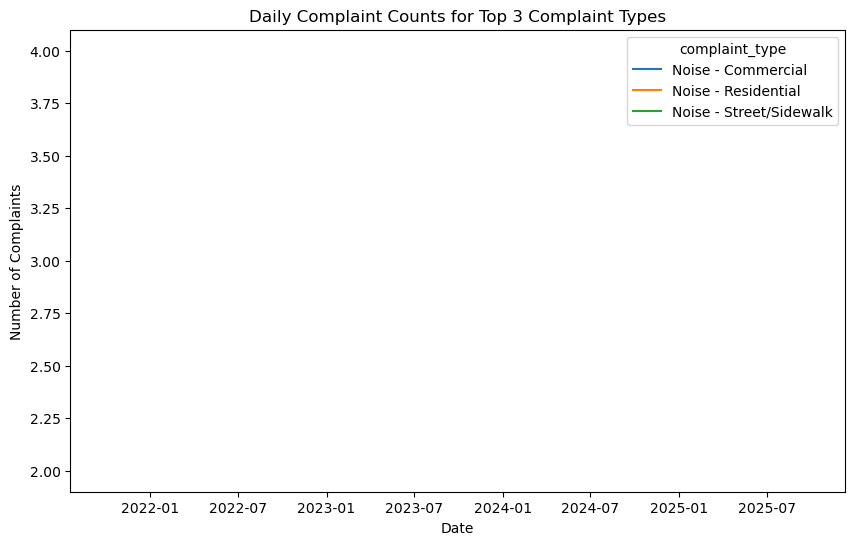

In [34]:
# Using the functions
data_1 = get_data_for_visual_1()
plot_visual_1(data_1)

In [35]:
pip install mplcursors

Note: you may need to restart the kernel to use updated packages.


In [36]:
from sqlalchemy import create_engine
import pandas as pd

def get_data_for_visual_2() -> pd.DataFrame:
    """
    Retrieve data for visual 2 from the database.

    Returns:
    - pd.DataFrame: DataFrame containing data for visual 2.
    """
    query = """
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM complaints
    WHERE zipcode = '10027' AND complaint_created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
    engine = create_engine(DATABASE_URL)
    return pd.read_sql(query, engine)

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_visual_2(dataframe: pd.DataFrame) -> None:
    """
    Plot visual 2 using the provided DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing data for visual 2.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 8))
    plt.barh(dataframe['complaint_type'], dataframe['complaint_count'], color='skyblue')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Complaint Type')
    plt.title('Top 10 Complaint Types in Zip Code 10027 (Oct 1, 2018 - Sep 30, 2023)')
    plt.gca().invert_yaxis()
    plt.show()


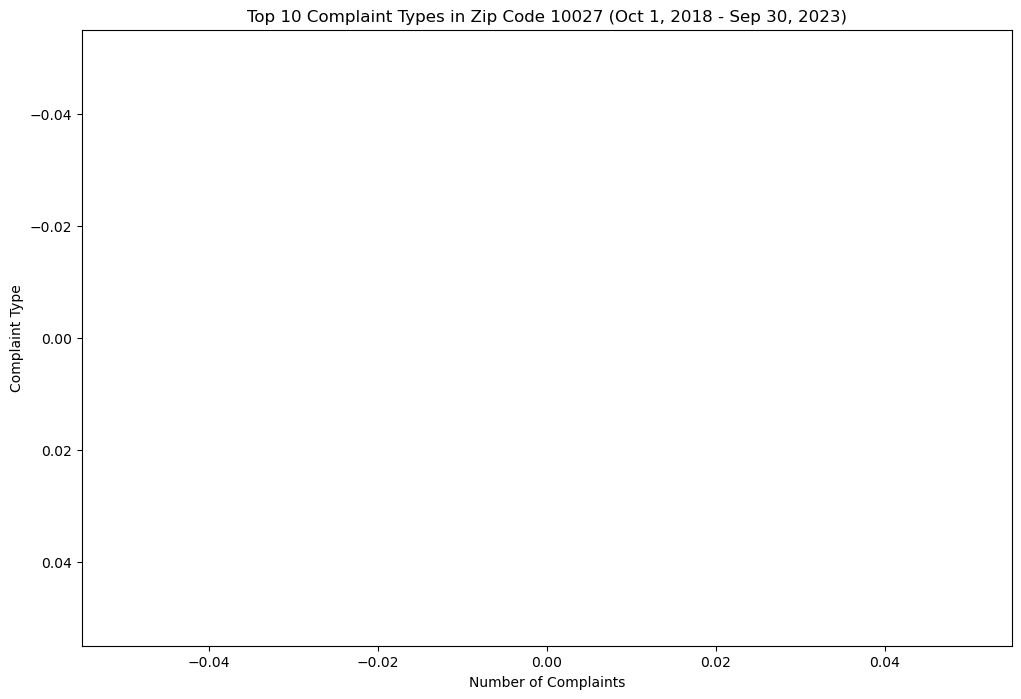

In [38]:
data_2 = get_data_for_visual_2()
plot_visual_2(data_2)

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import mplcursors
from ipywidgets import interact, widgets

def update_plot(zip_code: str) -> None:
    """
    Update and display the plot for the specified zip code.

    Parameters:
    - zip_code (str): The zip code for which to display the plot.

    Returns:
    - None
    """
    query = f"""
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM complaints
    WHERE zipcode = '{zip_code}' AND complaint_created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    data = pd.read_sql(query, engine)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(data['complaint_type'], data['complaint_count'], color='skyblue')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Complaint Type')
    plt.title(f'Top 10 Complaint Types in Zip Code {zip_code} (Oct 1, 2018 - Sep 30, 2023)')

    # Add interactivity with mplcursors
    mplcursors.cursor(hover=True)

    plt.gca().invert_yaxis()
    plt.show()

# Replace with your actual database URL
DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
engine = create_engine(DATABASE_URL)

# Get unique zip codes from the dataset
unique_zip_codes = pd.read_sql("SELECT DISTINCT zipcode FROM complaints;", engine)['zipcode'].tolist()

# Check if '10027' is in the list, if not, choose the first available zip code
default_zip_code = '10027' if '10027' in unique_zip_codes else unique_zip_codes[0] if unique_zip_codes else None

if default_zip_code:
    # Create a dropdown widget
    zip_code_dropdown = widgets.Dropdown(
        options=unique_zip_codes,
        value=default_zip_code,
        description='Zip Code:'
    )

    # Use the interact function to update the plot based on the selected zip code
    interact(update_plot, zip_code=zip_code_dropdown)
else:
    print("No zip codes available in the dataset.")

interactive(children=(Dropdown(description='Zip Code:', options=('10014', '10009', '10030', '10004', '10033', …

In [40]:
import pandas as pd
from sqlalchemy import create_engine

def get_data_for_visual_3() -> pd.DataFrame:
    """
    Retrieve data for creating visualizations.

    Returns:
    - pd.DataFrame: Merged data containing average rent, tree count, and complaint count by zipcode.
    """
    query_rent = """
    SELECT zipcode, AVG(average_rent) AS avg_rent
    FROM average_rent
    WHERE date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY zipcode;
    """
    query_trees = """
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode;
    """
    query_complaints = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM complaints
    WHERE complaint_created_date >= '2015-01-01' and complaint_created_date <='2023-09-30'
    GROUP BY zipcode;
    """

    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
    engine = create_engine(DATABASE_URL)

    rent_data = pd.read_sql(query_rent, engine)
    tree_data = pd.read_sql(query_trees, engine)
    complaint_data = pd.read_sql(query_complaints, engine)

    merged_data = pd.merge(rent_data, tree_data, on='zipcode', how='outer')
    return pd.merge(merged_data, complaint_data, on='zipcode', how='outer')


In [41]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_visual_3(dataframe: pd.DataFrame) -> None:
    """
    Plot visualizations based on merged data containing average rent, tree count, and complaint count by zipcode.

    Args:
    - dataframe (pd.DataFrame): Merged data.

    Returns:
    - None
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Subplot 1: Rent vs. Number of Trees
    ax1.scatter(dataframe['avg_rent'], dataframe['tree_count'], color='green')
    ax1.set_title('Average Rent vs. Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')

    # Subplot 2: Rent vs. Number of Complaints
    ax2.scatter(dataframe['avg_rent'], dataframe['complaint_count'], color='red')
    ax2.set_title('Average Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')

    plt.tight_layout()
    plt.show()


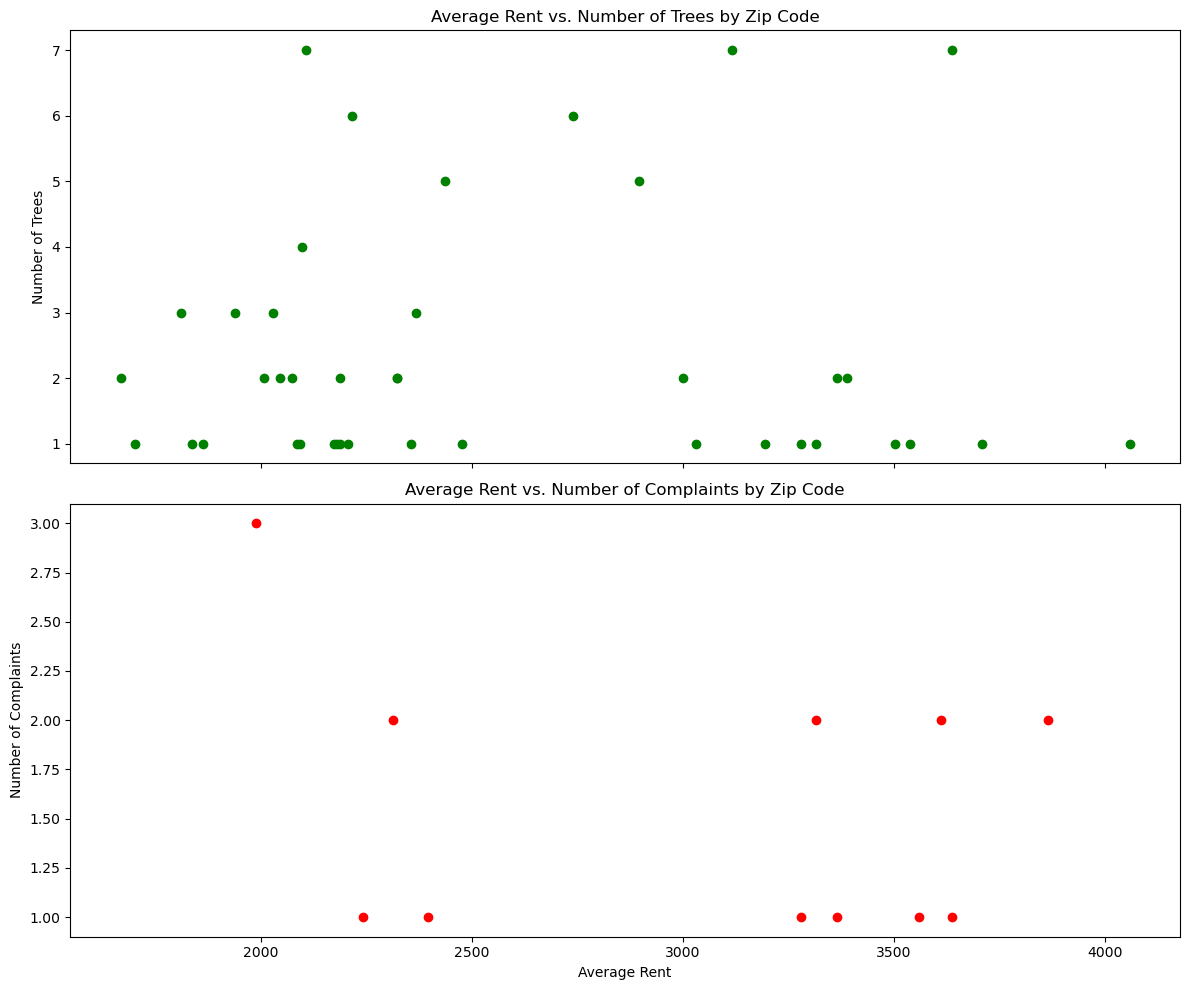

In [42]:
data_3 = get_data_for_visual_3()
plot_visual_3(data_3)

In [43]:
import pandas as pd
from sqlalchemy import create_engine

def get_data_for_visual_4() -> pd.DataFrame:
    """
    Get data for visualizing the relationship between average rent and complaint count by zipcode.

    Returns:
    - pd.DataFrame: Merged data.
    """
    query_rent = """
    SELECT zipcode, AVG(average_rent) AS avg_rent
    FROM average_rent
    WHERE date BETWEEN '2023-09-01' AND '2023-09-30'
    GROUP BY zipcode;
    """
    query_complaints = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM complaints
    WHERE complaint_created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
    engine = create_engine(DATABASE_URL)

    rent_data = pd.read_sql(query_rent, engine)
    complaint_data = pd.read_sql(query_complaints, engine)

    merged_data = pd.merge(rent_data, complaint_data, on='zipcode', how='inner')

    bins = range(0, int(merged_data['avg_rent'].max()) + 1000, 1000)
    labels = [f"${i}-{i + 999}" for i in bins[:-1]]
    merged_data['rent_bin'] = pd.cut(merged_data['avg_rent'], bins=bins, labels=labels, right=False)

    return merged_data


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_visual_4(dataframe: pd.DataFrame) -> None:
    """
    Plot a boxplot to visualize the relationship between average rent and complaint count by zipcode.

    Args:
    - dataframe (pd.DataFrame): Merged data.
    """
    bins = range(0, int(dataframe['avg_rent'].max()) + 1000, 1000)
    labels = [f"${i}-{i + 999}" for i in bins[:-1]]

    plt.figure(figsize=(12, 6))
    plt.boxplot([dataframe[dataframe['rent_bin'] == label]['complaint_count'] for label in labels], labels=labels)
    plt.xlabel('Average Rent (Sep 2023)')
    plt.ylabel('Number of 311 Complaints (Oct 2022 - Sep 2023)')
    plt.title('311 Complaints vs. Average Rent by Zipcode')
    plt.xticks(rotation=45)
    plt.show()


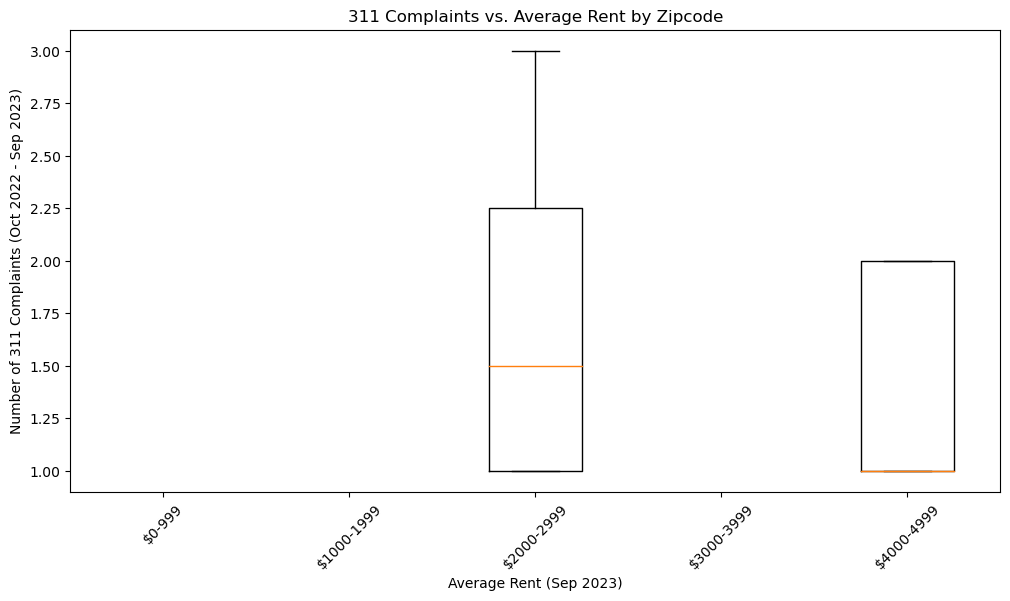

In [45]:
data_4 = get_data_for_visual_4()
plot_visual_4(data_4)

In [48]:
import pandas as pd
from sqlalchemy import create_engine

def get_data_for_visual_5() -> pd.DataFrame:
    """
    Retrieve data for Visual 5: Complaints within 1,000 meters of a specific location.

    Returns:
    - pd.DataFrame: Dataframe containing latitude and longitude of complaints.
    """
    query = """
    SELECT 
        latitude, 
        longitude
    FROM 
        complaints
    WHERE 
        complaint_created_date BETWEEN '2023-01-01' AND '2023-09-30'
        AND ST_DWithin(
            ST_MakePoint(CAST(longitude AS FLOAT), CAST(latitude AS FLOAT))::geography,
            ST_MakePoint(-73.96253174434912, 40.80737875669467)::geography,
            1000
        );
    """
    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
    engine = create_engine(DATABASE_URL)
    return pd.read_sql(query, engine)


In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

def plot_visual_5(dataframe: pd.DataFrame) -> None:
    """
    Plot Visual 5: Map of 311 Incidents within 1 km Radius.

    Parameters:
    - dataframe (pd.DataFrame): Dataframe containing latitude and longitude of complaints.
    """
    gdf = gpd.GeoDataFrame(
        dataframe, 
        geometry=gpd.points_from_xy(dataframe.longitude, dataframe.latitude),
        crs="EPSG:4326" 
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='blue', markersize=5)
    plt.title('311 Incidents within 1 km Radius')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


ValueError: aspect must be finite and positive 

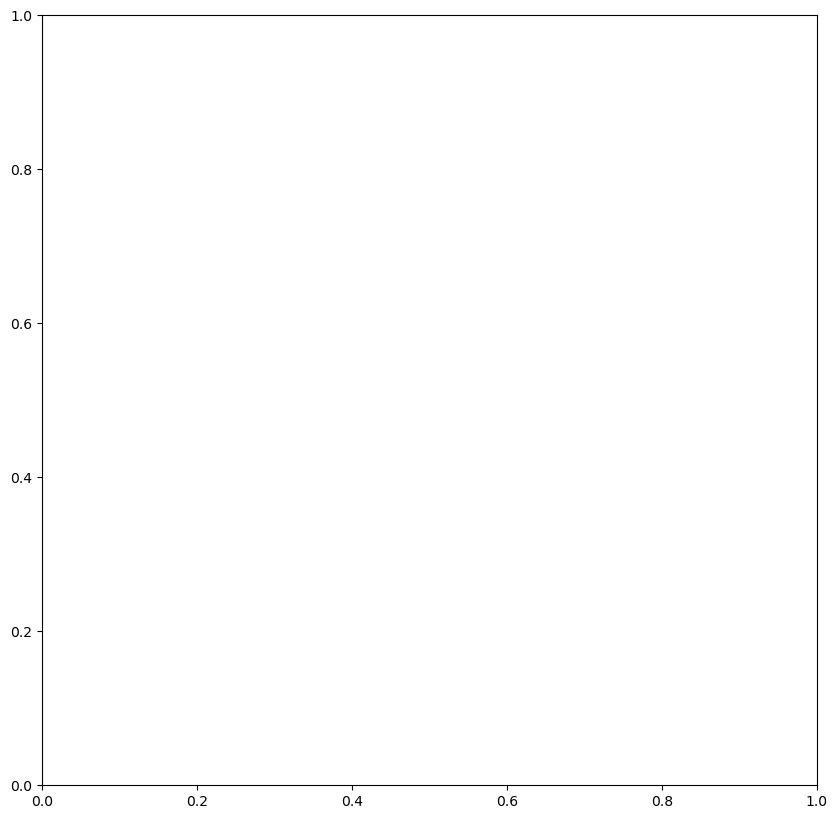

In [50]:
data_5 = get_data_for_visual_5()
plot_visual_5(data_5)

In [51]:
import pandas as pd
from sqlalchemy import create_engine

def get_data_for_visual_6() -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Get data for Visual 6: Trees and Complaints for New Tree Requests.

    Returns:
    - Tuple containing two DataFrames: data_trees (latitude and longitude of all trees) 
      and data_complaints (latitude and longitude of complaints for new tree requests).
    """
    query_trees = """
    SELECT latitude, longitude
    FROM trees;
    """
    query_complaints = """
    SELECT latitude, longitude
    FROM complaints
    WHERE complaint_type = 'New Tree Request'
    AND complaint_created_date BETWEEN '2018-10-01' AND '2023-09-30';
    """

    DATABASE_URL = 'postgresql://vivianhua@localhost:5432/try_16'
    engine = create_engine(DATABASE_URL)
    data_trees = pd.read_sql(query_trees, engine)
    data_complaints = pd.read_sql(query_complaints, engine)

    return data_trees, data_complaints

In [52]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_visual_6(dataframes: tuple[pd.DataFrame, pd.DataFrame]) -> None:
    """
    Plot Visual 6: Trees and Complaints for New Tree Requests.

    Args:
    - dataframes (Tuple): Tuple containing two DataFrames: data_trees and data_complaints.
    """
    data_trees, data_complaints = dataframes

    gdf_trees = gpd.GeoDataFrame(
        data_trees, 
        geometry=gpd.points_from_xy(data_trees.longitude, data_trees.latitude),
        crs='EPSG:4326'
    )

    gdf_complaints = gpd.GeoDataFrame(
        data_complaints, 
        geometry=gpd.points_from_xy(data_complaints.longitude, data_complaints.latitude),
        crs='EPSG:4326'
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_trees.plot(ax=ax, color='green', markersize=5, label='Trees')
    gdf_complaints.plot(ax=ax, color='red', markersize=5, label='New Tree Requests')
    plt.title('Trees and New Tree Request Complaints in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


ValueError: aspect must be finite and positive 

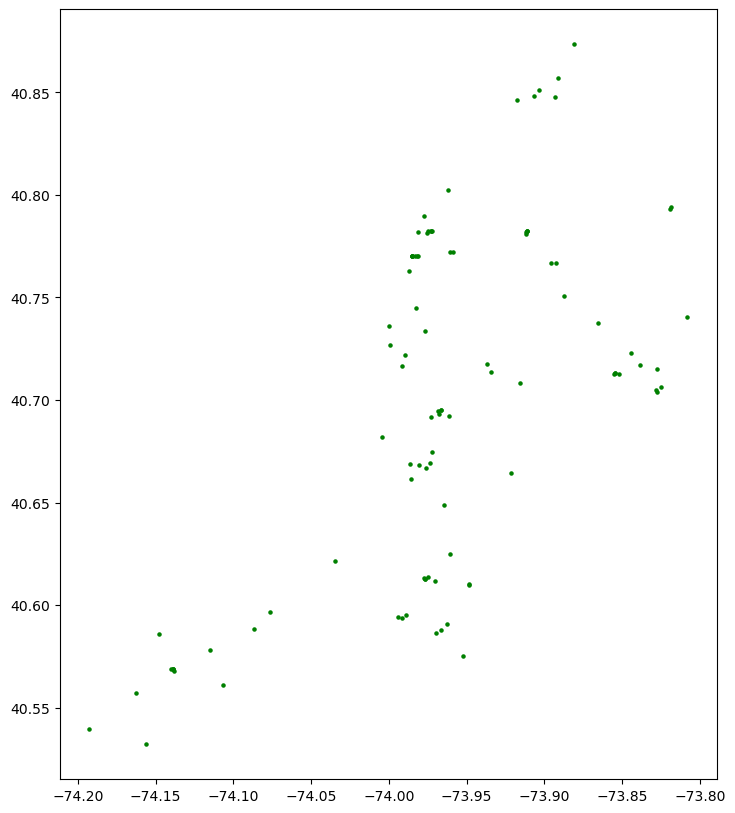

In [53]:
data_6 = get_data_for_visual_6()
plot_visual_6(data_6)